<img src="./img/logo-ilsp.png" alt="Drawing" style="width: 90px; float: left"/>
<img src="./img/logo-proserve.png" alt="Drawing" style="width: 150px; float: right"/>

<br>
<br>
<center>
    <font size=6><b> AI/ML Experiment - Vehicle Theft Detection</b></font>
    

# Third notebook - Evaluating and conclusions

In [2]:
%%capture
!pip install --upgrade pip

In [3]:
%%capture
!pip install xgboost geohash_hilbert googlemaps pydotplus treeinterpreter imblearn pyarrow bayesian-optimization

In [4]:
%%capture
!conda install seaborn==0.9.0 -y

In [8]:
# important libraries used throughout notebook
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import geohash_hilbert as ghh
from sklearn import preprocessing
import matplotlib.pyplot as plt
import geohash_hilbert as ghh


In [9]:
# This command is called a Magic, and modifies the way that Jupyter displays images, graphs, etc...
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

# This is setting pandas settings so that we can see more/ess rows and columns of our dataframes.
# We end up with a lot of columns later on, so we set the number of columns high.
pd.options.display.max_rows = 50
pd.options.display.max_columns = 500

# np.set_printoptions(precision=2)

In [10]:
# For Visualizing trees
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, recall_score, \
precision_score, confusion_matrix, precision_recall_curve, make_scorer

In [11]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823


def print_confusion_matrix(confusion_matrix, class_names = ['no_robo', 'robo'], figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [12]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823


def print_confusion_matrix(confusion_matrix, class_names = ['no_robo', 'robo'], figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [13]:
def print_roc(y_true, y_predicted):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(false_positive_rate, true_positive_rate, marker='.')
    # show the plot
    plt.show()


def print_precision_recall_curve(y_true, y_predicted):
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_predicted)
    # plot no skill
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    # show the plot
    plt.show()

In [14]:
def print_decision_tree(decision_tree):
    dot_data = StringIO()
    export_graphviz(decision_tree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph.create_png()

# Load our datasets


In [41]:
X_train = pd.read_feather('X_train')
X_test = pd.read_feather('X_test')
y_train = pd.read_feather('y_train').values.ravel()
y_test = pd.read_feather('y_test').values.ravel()

In [16]:
X_train.head()

,has_custody,customer_id_4,customer_id_5,customer_id_16,customer_id_19,customer_id_21,customer_id_22,customer_id_25,customer_id_29,customer_id_31,customer_id_35,customer_id_36,customer_id_37,customer_id_39,customer_id_40,customer_id_41,customer_id_45,customer_id_46,customer_id_47,customer_id_50,customer_id_51,customer_id_53,customer_id_57,customer_id_68,customer_id_69,customer_id_74,customer_id_79,customer_id_81,customer_id_82,customer_id_83,customer_id_93,customer_id_102,customer_id_108,customer_id_118,customer_id_141,customer_id_142,customer_id_147,customer_id_152,customer_id_156,customer_id_158,customer_id_161,customer_id_183,customer_id_184,customer_id_189,customer_id_200,customer_id_206,product_ABARROTES,product_CUIDADO DE PIEL,product_FARMACEUTICA,product_LACTEOS,product_MATERIAL ELECTRICO,product_PAPELERIA,product_PAQUETERIA,product_PERFUMERIA,product_QUIMICOS,product_TABACO,product_TEXTIL,product_VINOS Y LICORES,transport_line_200.0,transport_line_262.0,transport_line_264.0,transport_line_270.0,transport_line_275.0,transport_line_293.0,transport_line_342.0,transport_line_345.0,transport_line_371.0,transport_line_376.0,transport_line_408.0,transport_line_428.0,transport_line_442.0,transport_line_445.0,transport_line_451.0,transport_line_490.0,transport_line_496.0,transport_line_499.0,transport_line_500.0,transport_line_606.0,transport_line_761.0,transport_line_996.0,transport_line_1017.0,transport_line_1049.0,transport_line_1388.0,transport_line_1544.0,transport_line_1635.0,transport_line_1685.0,transport_line_1740.0,transport_line_1773.0,transport_line_1783.0,transport_line_1918.0,transport_line_2407.0,transport_line_2507.0,transport_line_2634.0,transport_line_2696.0,transport_line_2879.0,transport_line_2992.0,transport_line_3022.0,transport_line_3157.0,transport_line_3327.0,transport_line_3437.0,transport_line_3521.0,transport_line_3544.0,transport_line_3833.0,transport_line_4030.0,transport_line_4197.0,transport_line_4388.0,transport_line_4634.0,transport_line_4665.0,transport_line_4884.0,transport_line_5091.0,transport_line_5095.0,transport_line_5126.0,transport_line_5146.0,transport_line_5152.0,transport_line_5304.0,transport_line_5305.0,transport_line_6063.0,transport_line_6236.0,transport_line_6522.0,transport_line_6637.0,transport_line_6656.0,transport_line_6941.0,transport_line_7278.0,transport_line_7805.0,transport_line_8055.0,origin_id_6532,origin_id_6554,origin_id_6719,origin_id_6988,origin_id_7140,origin_id_7141,origin_id_7142,origin_id_7193,origin_id_7301,origin_id_7413,origin_id_7532,origin_id_7534,origin_id_7551,origin_id_7563,origin_id_7595,origin_id_7606,origin_id_7666,origin_id_7740,origin_id_7943,origin_id_8040,origin_id_8102,origin_id_8226,origin_id_8320,origin_id_8339,origin_id_8689,origin_id_13405,origin_id_13782,origin_id_13898,origin_id_14072,origin_id_14399,origin_id_14571,origin_id_14692,origin_id_14840,origin_id_15180,origin_id_15220,origin_id_15413,origin_id_15558,origin_id_15648,origin_id_15864,origin_id_15996,origin_id_16009,origin_id_16057,origin_id_16286,origin_id_16317,origin_id_16364,origin_id_16622,origin_id_16687,origin_id_16704,origin_id_17256,origin_id_17838,origin_id_18134,origin_id_21168,origin_id_21896,origin_id_21897,origin_id_21899,origin_id_21915,origin_id_22167,origin_id_22168,origin_id_22627,origin_id_22866,origin_id_23039,destination_id_6190,destination_id_6254,destination_id_6424,destination_id_6663,destination_id_6972,destination_id_7028,destination_id_7029,destination_id_7193,destination_id_7197,destination_id_7352,destination_id_7437,destination_id_7532,destination_id_7551,destination_id_7606,destination_id_7612,destination_id_7942,destination_id_7945,destination_id_8022,destination_id_8102,destination_id_8188,destination_id_8208,destination_id_8210,destination_id_8229,destination_id_8273,destination_id_8299,destination_id_8357,destination_id_8626,destination_id_10110,destination_id_10492,destination_id_13391,destination_id_13405,destination_id_13531,destination_id_137

# Modelling Utils
Here we start the modelling process
first import some importance libraries

In [15]:
# For Visualizing trees
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, recall_score, \
precision_score, confusion_matrix, precision_recall_curve, make_scorer

In [16]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823


def print_confusion_matrix(confusion_matrix, class_names = ['no_robo', 'robo'], figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [17]:
# https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5

def show_metrics(y_true, y_score):
    y_true = y_true.astype(float)
    y_score = y_score.astype(float)
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))

    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    # Precision
    precision = tp / (tp + fp)
    # True negatvie tate (specificity)
    tnr = 1 - fpr
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    # ROC-AUC for binary classification
    auc = (tpr+tnr) / 2
    # MCC
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    print("ACCURACY : {0:.2f}% (What proportion of classes are being classified as theft or not theft correctly?)".format(accuracy*100))
    print("PRECISION: {0:.2f}% (If predicted as theft, how likely is it to be theft?)".format(precision*100))
    print("RECALL   : {0:.2f}% (If it was theft, how likely is it I predicted it?)".format(tpr*100))
    print()
    print("F1: {0:.4f}".format(f1))
    print()
    print("baseline proportion of thefts is ~ 0.09%")
    print("with this model, a journey predicted as theft is {0:.2f}x more likely to be stolen".format(precision/0.0009))
#     print("ROC-AUC: {0:.4f}".format(auc))

In [18]:
def print_roc(y_true, y_predicted):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(false_positive_rate, true_positive_rate, marker='.')
    # show the plot
    plt.show()


def print_precision_recall_curve(y_true, y_predicted):
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_predicted)
    # plot no skill
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    # show the plot
    plt.show()

In [19]:
def print_decision_tree(decision_tree):
    dot_data = StringIO()
    export_graphviz(decision_tree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph.create_png()

# Imbalanced learn
We will interchangeably use different resampled datasets. This may help deal with the large class imbalance.

In [22]:
# Oversampling
from imblearn.over_sampling import SMOTE
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)

# Undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=0, replacement=False)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print('number of thefts vs non-thefts in oversampled dataset =', np.unique(y_train_smote, return_counts=True))
print('number of thefts vs non-thefts in undersampled dataset =', np.unique(y_train_under, return_counts=True))

number of thefts vs non-thefts in oversampled dataset = (array([0, 1]), array([775006, 775006]))
number of thefts vs non-thefts in undersampled dataset = (array([0, 1]), array([3540,  708]))


# Evaluating and ranking our models

https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba
Use precision and recall to focus on small positive class — When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall.

### Models tried:
1. (Unsupervised learning & Visualization) K-Means Clustering & PCA
2. K-Nearest Neighbours
2. Logistic Regression
3. Decision Tree
4. Random Forest
5. XGBoost
6. Neural Network (Deep Learning)

### Overall results
...

In [5]:
import boto3
import sagemaker
import sagemaker.xgboost
import time
from time import gmtime, strftime
import copy
# get the URI for new container
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role

In [17]:
# Create our final test set
df_all = pd.read_csv("s3://ilsp-stole-data/to_predict/info_to_predict.csv")#, encoding = "Windows-1252",
#                           error_bad_lines=False)

column_rename_dict = {"ax_transport_line_id":"transport_line",
                      "id_unit_type":"unit_type_id"}
df_all = df_all.rename(columns=column_rename_dict)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,5,6,7,19,20,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
# Now we have to do all the same stuff to this data frame that we did to the previous one
df_all = df_all.drop_duplicates(subset=['id_bitacora'])
df_all['theft_time'] = pd.to_datetime(df_all.theft_time).dt.time
df_all['theft_date'] = pd.to_datetime(df_all.theft_date, dayfirst=True).dt.date
df_all['start_time'] = pd.to_datetime(df_all.start_time).dt.time
df_all['start_date'] = pd.to_datetime(df_all.start_date, dayfirst=True).dt.date
df_all['end_time'] = pd.to_datetime(df_all.end_time).dt.time
df_all['end_date'] = pd.to_datetime(df_all.end_date, dayfirst=True).dt.date
df_all['start_dayofweek'] = df_all.start_date.apply(lambda x: x.weekday())
df_all['start_month'] = df_all.start_date.apply(lambda x: x.month)
df_all['theft_dayofweek'] = df_all.theft_date.apply(lambda x: x.weekday())
df_all['theft_month'] = df_all.theft_date.apply(lambda x: x.month)
peak_range = range(4, 11)
df_all['peak'] = df_all['theft_time'].apply(lambda x: 1 if x.hour in peak_range else 0)
df_all['has_custody'] = ((df_all['has_custody']) | (df_all['monitoring_type_id'] == 86) |
                         (df_all['monitoring_type_id'] == 94))
vehicle_types = {77:"camioneta",
                 78:"camioneta", 
                 79:"camioneta",
                 80:"camioneta",
                 81:"camioneta",
                 82:"camioneta",
                 83:"camioneta",
                 84:"camioneta",
                 85:"camioneta",
                 86:"full",
                 87:"camioneta",
                 88:"camioneta",
                 89:"camioneta",
                 90:"trailer",
                 91:"camioneta",
                 105:"camioneta",
                 114:"trailer",
                 115:"camioneta",
                 125:"camioneta",
                 126:"camioneta"}
df_all = df_all.replace({"unit_type_id": vehicle_types})
monitoring_types = {5: "activo",               # activo
                    86:"activo",      # activo with custodia
                    93:"inteligente",          # inteligente
                    94:"inteligente"} # inteligente with custodia
df_all = df_all.replace({"monitoring_type_id": monitoring_types})
df_all = df_all.drop(df_all[(df_all['latitude'].isna()) & (df_all['municipality'].isna()) &
                            (df_all['is_theft'] == 1)].index)
df_thefts = df_all[df_all['is_theft'] == 1]
df_nonthefts = df_all[df_all['is_theft']==0]
df_all['start_date'] = df_all['start_date'].fillna(df_all['theft_date'])
df_all['start_date'] = df_all['start_date'].fillna(df_all['end_date'])
df_all = df_all.dropna(subset=['start_date'])
df_all['start_dayofweek'] = df_all.start_date.apply(lambda x: x.weekday())
df_all['start_month'] = df_all.start_date.apply(lambda x: x.month)

df_all['theft_dayofweek'] = df_all.theft_date.apply(lambda x: x.weekday())
df_all['theft_month'] = df_all.theft_date.apply(lambda x: x.month)
df_all_checkpoint = df_all.copy()

In [19]:
df_all.head(1)

,id_bitacora,latitude,longitude,street,colony,municipality,district,country,postcode,is_theft,transport_line,customer_id,product,start_date,start_time,end_date,end_time,has_custody,monitoring_type_id,theft_date,theft_time,total_risk_zone,unit_type_id,resolution_des,resolution,origin_id,destination_id,alert1,alert2,alert3,alert4,alert5,alert6,alert7,ws,start_dayofweek,start_month,theft_dayofweek,theft_month,peak
0,636988261212037131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8825,186,NaN,2019-08-03,05:44:41,2019-08-03,05:45:10,False,activo,NaT,NaT,0,trailer,NaN,NaN,25302,25304,0,0,0,0,0,0,0,0,5,8,NaN,NaN,0


In [81]:
df_all = df_all_checkpoint.copy()
streets_dict = {
                "3645":"BACARDI TULTITLAN - MONTERREY",
                "4317":"BOMY TOLUCA - GUERRERO",
                "8062":"LALA VERACRUZ - SAMS CORDOBA",
                "9688":"tehuacan - oaxaca",
                "11489":"Ruta de riesgo Av-Lopez Portillo",
                "11500":"Ruta de Riesgo - Arco Norte dirección Puebla",
                "11568":"AUTOPISTA MEXICO QUERETARO",
                "11569":"AUTOPISTA MEXICO PUEBLA",
                "11570":"AUTOPISTA PUEBLA ORIZABA CUITLAHUAC",
                "11584":"Circuito Exterior"
               }

def one_hot_encode_column(df, column, dangerous_examples):
    ohe_all = pd.get_dummies(df[column])
    ohe_all.columns = ohe_all.columns.astype(str)
    unwanted_columns = ohe_all.drop(columns=dangerous_examples, errors='ignore').columns
    ohe = pd.get_dummies(df[column])
    ohe.columns = ohe.columns.astype(str)
    ohe = ohe.drop(columns=unwanted_columns, errors='ignore')
    ohe = ohe.add_prefix(column+"_")
    df = pd.concat([df,ohe], axis=1, sort=False)
    return df

dangerous_columns = ["customer_id","product","transport_line","origin_id","destination_id"]
for column in dangerous_columns:

    with open("./dangerous_examples/{}.txt".format(column), 'r') as f:
        contents = f.read()
        dangerous_examples = contents.splitlines()
    # horrible hack because transportline was encoded as a float...
    if column == 'transport_line':
        dangerous_examples = [example[:-2] for example in dangerous_examples]
    df_all = one_hot_encode_column(df=df_all, column=column, dangerous_examples=dangerous_examples)
    print('added', column)
df_all.head()

added customer_id
added product
added transport_line
added origin_id
added destination_id


,id_bitacora,latitude,longitude,street,colony,municipality,district,country,postcode,is_theft,transport_line,customer_id,product,start_date,start_time,end_date,end_time,has_custody,monitoring_type_id,theft_date,theft_time,total_risk_zone,unit_type_id,resolution_des,resolution,origin_id,destination_id,alert1,alert2,alert3,alert4,alert5,alert6,alert7,ws,start_dayofweek,start_month,theft_dayofweek,theft_month,peak,customer_id_4,customer_id_5,customer_id_16,customer_id_19,customer_id_21,customer_id_22,customer_id_25,customer_id_31,customer_id_35,customer_id_36,customer_id_39,customer_id_40,customer_id_41,customer_id_45,customer_id_46,customer_id_47,customer_id_50,customer_id_51,customer_id_53,customer_id_57,customer_id_68,customer_id_69,customer_id_79,customer_id_81,customer_id_82,customer_id_83,customer_id_102,customer_id_108,customer_id_118,customer_id_142,customer_id_147,customer_id_152,customer_id_156,customer_id_158,customer_id_184,customer_id_189,customer_id_200,customer_id_206,product_ABARROTES,product_CUIDADO DE PIEL,product_FARMACEUTICA,product_LACTEOS,product_MATERIAL ELECTRICO,product_PAPELERIA,product_PAQUETERIA,product_PERFUMERIA,product_QUIMICOS,product_TABACO,product_TEXTIL,product_VINOS Y LICORES,transport_line_262,transport_line_264,transport_line_270,transport_line_275,transport_line_293,transport_line_342,transport_line_345,transport_line_371,transport_line_376,transport_line_408,transport_line_428,transport_line_442,transport_line_445,transport_line_451,transport_line_490,transport_line_496,transport_line_499,transport_line_500,transport_line_606,transport_line_761,transport_line_1017,transport_line_1049,transport_line_1388,transport_line_1544,transport_line_1635,transport_line_1685,transport_line_1740,transport_line_1773,transport_line_1918,transport_line_2407,transport_line_2507,transport_line_2634,transport_line_2696,transport_line_2879,transport_line_3022,transport_line_3157,transport_line_3327,transport_line_3437,transport_line_3521,transport_line_3544,transport_line_3833,transport_line_4030,transport_line_4197,transport_line_4388,transport_line_4634,transport_line_4665,transport_line_4884,transport_line_5091,transport_line_5095,transport_line_5146,transport_line_5152,transport_line_6236,transport_line_6522,transport_line_6637,transport_line_6656,transport_line_6941,transport_line_7278,transport_line_8055,origin_id_6532,origin_id_6554,origin_id_6988,origin_id_7140,origin_id_7141,origin_id_7142,origin_id_7193,origin_id_7301,origin_id_7413,origin_id_7532,origin_id_7534,origin_id_7551,origin_id_7563,origin_id_7595,origin_id_7606,origin_id_7666,origin_id_7740,origin_id_7943,origin_id_8102,origin_id_8226,origin_id_8320,origin_id_8339,origin_id_8689,origin_id_13405,origin_id_13782,origin_id_13898,origin_id_14072,origin_id_14399,origin_id_14571,origin_id_14692,origin_id_14840,origin_id_15180,origin_id_15220,origin_id_15413,origin_id_15558,origin_id_15648,origin_id_15864,origin_id_15996,origin_id_16009,origin_id_16057,origin_id_16286,origin_id_16317,origin_id_16364,origin_id_16622,origin_id_16687,origin_id_16704,origin_id_17256,origin_id_17838,origin_id_18134,origin_id_21896,origin_id_21897,origin_id_21899,origin_id_21915,origin_id_22167,origin_id_22168,origin_id_22866,origin_id_23039,destination_id_6190,destination_id_6254,destination_id_6424,destination_id_6663,destination_id_6972,destination_id_7028,destination_id_7029,destination_id_7193,destination_id_7197,destination_id_7352,destination_id_7532,destination_id_7551,destination_id_7606,destination_id_7612,destination_id_7942,destination_id_7945,destination_id_8022,destination_id_8102,destination_id_8188,destination_id_8208,destination_id_8210,destination_id_8229,destination_id_8273,destination_id_8299,destination_id_8357,destination_id_8626,destination_id_10110,destination_id_10492,destination_id_13405,destination_id_13531,destination_id_13798,destination_id_13898,destination_id_13953,destination_id_14265,destination_id_14871,destination_id_15093,destination_i

In [82]:
df_all = pd.concat([df_all,pd.get_dummies(df_all['unit_type_id'])], axis=1, sort=False)
df_all = pd.concat([df_all,pd.get_dummies(df_all['start_dayofweek']).add_prefix('startdayofweek_')], axis=1, sort=False)
df_all = pd.concat([df_all,pd.get_dummies(df_all['start_month']).add_prefix('month_')], axis=1, sort=False)
df_all = pd.concat([df_all,pd.get_dummies(df_all['monitoring_type_id'])], axis=1, sort=False).drop(columns=['activo'])
peak_hours = [i for i in range(4, 11)]
df_all['peak_start'] = df_all['start_time'].apply(lambda x: x.hour in peak_hours).astype(int)

In [83]:
pre_planned_data = pd.read_csv("s3://ilsp-stole-data/to_predict/into_to_predict_geo.csv")
pre_planned_data = pre_planned_data.rename(columns=streets_dict)
with open("./dangerous_examples/{}.txt".format('geohashes'), 'r') as f:
        contents = f.read()
        common_geohashes = contents.splitlines()   
for ghash in common_geohashes:
    pre_planned_data = pre_planned_data.rename(columns={str(ghash):"geohash_"+str(ghash)})
X_test = df_all.merge(pre_planned_data.rename(columns={"bitacora": "id_bitacora"}), on='id_bitacora')
X_test = X_test.drop(columns=['id_bitacora', 'street', 'colony', 'municipality', 'district', 'postcode', 'transport_line',
                        'customer_id', 'product', 'start_date', 'start_time', 'end_date','end_time','monitoring_type_id',
                        'theft_date', 'theft_time', 'unit_type_id', 'origin_id', 'destination_id','resolution_des',
                        'resolution', 'alert1', 'alert2', 'alert3', 'alert4','alert5', 'alert6', 'alert7', 'ws',
                        'start_month', 'start_dayofweek','theft_dayofweek', 'theft_month', 'peak', 'total_risk_zone',
                             'country', 95, ])

# X_test = X_test.drop(columns=['postcode_str', 'geohash', 'theft_time_slot'])

X_test = X_test.drop(columns=['latitude', 'longitude'])
for geohash in common_geohashes:
    X_test['geohash_'+str(geohash[:-1])] = 0
for geohash in common_geohashes:
    rows = X_test[X_test['geohash_'+str(geohash)] == 1].index
    X_test.at[rows, 'geohash_'+str(geohash[:-1])] = 1

X_test = X_test.fillna(0)
X_test_binary_vs = X_test.drop(columns=['time_travel']).astype(int)
X_test_binary_vs[X_test_binary_vs != 0] = 1
X_test = pd.concat([X_test_binary_vs, X_test['time_travel']], axis=1)
y_test = X_test['is_theft']
X_test = X_test.drop(columns=['is_theft'])
###
# WE NEED THE SAME SCALER FROM THE OTHER NOTEBOOK! Can we save it?
###
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_test['time_travel'].to_numpy().reshape(-1, 1))
scaler.mean_, scaler.var_=23826.996298893664, 630217978.2902493
scaler.transform(X_test)
X_test['time_travel'] = scaler.transform(X_test['time_travel'].to_numpy().reshape(-1, 1))
X_test.to_feather('X_test_f')
pd.DataFrame(y_test, columns=['is_theft']).to_feather('y_test_f')
X_test = pd.read_feather('X_test_f')
y_test = pd.read_feather('y_test_f').values.ravel()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:38: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [95]:
with open("./utils/column_names.txt", 'r') as f:
    contents = f.read()
    column_names = contents.splitlines()

# horrible hack because transportline was encoded as a float...
for i, column in enumerate(column_names):
    if column[:9] == 'transport':
        column_names[i] = column[:-2]

for column in column_names:
    if not column in X_test.columns:
        X_test[column] = 0

In [98]:
X_test = X_test[column_names]

In [100]:
# X_test.to_feather('X_test_f')

In [24]:
X_test = pd.read_feather('X_test_f')
y_test = pd.read_feather('y_test_f').values.ravel()
X_test.head()

,has_custody,customer_id_4,customer_id_5,customer_id_16,customer_id_19,customer_id_21,customer_id_22,customer_id_25,customer_id_29,customer_id_31,customer_id_35,customer_id_36,customer_id_37,customer_id_39,customer_id_40,customer_id_41,customer_id_45,customer_id_46,customer_id_47,customer_id_50,customer_id_51,customer_id_53,customer_id_57,customer_id_68,customer_id_69,customer_id_74,customer_id_79,customer_id_81,customer_id_82,customer_id_83,customer_id_93,customer_id_102,customer_id_108,customer_id_118,customer_id_141,customer_id_142,customer_id_147,customer_id_152,customer_id_156,customer_id_158,customer_id_161,customer_id_183,customer_id_184,customer_id_189,customer_id_200,customer_id_206,product_ABARROTES,product_CUIDADO DE PIEL,product_FARMACEUTICA,product_LACTEOS,product_MATERIAL ELECTRICO,product_PAPELERIA,product_PAQUETERIA,product_PERFUMERIA,product_QUIMICOS,product_TABACO,product_TEXTIL,product_VINOS Y LICORES,transport_line_200,transport_line_262,transport_line_264,transport_line_270,transport_line_275,transport_line_293,transport_line_342,transport_line_345,transport_line_371,transport_line_376,transport_line_408,transport_line_428,transport_line_442,transport_line_445,transport_line_451,transport_line_490,transport_line_496,transport_line_499,transport_line_500,transport_line_606,transport_line_761,transport_line_996,transport_line_1017,transport_line_1049,transport_line_1388,transport_line_1544,transport_line_1635,transport_line_1685,transport_line_1740,transport_line_1773,transport_line_1783,transport_line_1918,transport_line_2407,transport_line_2507,transport_line_2634,transport_line_2696,transport_line_2879,transport_line_2992,transport_line_3022,transport_line_3157,transport_line_3327,transport_line_3437,transport_line_3521,transport_line_3544,transport_line_3833,transport_line_4030,transport_line_4197,transport_line_4388,transport_line_4634,transport_line_4665,transport_line_4884,transport_line_5091,transport_line_5095,transport_line_5126,transport_line_5146,transport_line_5152,transport_line_5304,transport_line_5305,transport_line_6063,transport_line_6236,transport_line_6522,transport_line_6637,transport_line_6656,transport_line_6941,transport_line_7278,transport_line_7805,transport_line_8055,origin_id_6532,origin_id_6554,origin_id_6719,origin_id_6988,origin_id_7140,origin_id_7141,origin_id_7142,origin_id_7193,origin_id_7301,origin_id_7413,origin_id_7532,origin_id_7534,origin_id_7551,origin_id_7563,origin_id_7595,origin_id_7606,origin_id_7666,origin_id_7740,origin_id_7943,origin_id_8040,origin_id_8102,origin_id_8226,origin_id_8320,origin_id_8339,origin_id_8689,origin_id_13405,origin_id_13782,origin_id_13898,origin_id_14072,origin_id_14399,origin_id_14571,origin_id_14692,origin_id_14840,origin_id_15180,origin_id_15220,origin_id_15413,origin_id_15558,origin_id_15648,origin_id_15864,origin_id_15996,origin_id_16009,origin_id_16057,origin_id_16286,origin_id_16317,origin_id_16364,origin_id_16622,origin_id_16687,origin_id_16704,origin_id_17256,origin_id_17838,origin_id_18134,origin_id_21168,origin_id_21896,origin_id_21897,origin_id_21899,origin_id_21915,origin_id_22167,origin_id_22168,origin_id_22627,origin_id_22866,origin_id_23039,destination_id_6190,destination_id_6254,destination_id_6424,destination_id_6663,destination_id_6972,destination_id_7028,destination_id_7029,destination_id_7193,destination_id_7197,destination_id_7352,destination_id_7437,destination_id_7532,destination_id_7551,destination_id_7606,destination_id_7612,destination_id_7942,destination_id_7945,destination_id_8022,destination_id_8102,destination_id_8188,destination_id_8208,destination_id_8210,destination_id_8229,destination_id_8273,destination_id_8299,destination_id_8357,destination_id_8626,destination_id_10110,destination_id_10492,destination_id_13391,destination_id_13405,destination_id_13531,destination_id_13798,destination_id_13898,destination_id_13953,destination_id_14265,destination_id_14871,destination_id_15093,destination_id_15095,desti

In [103]:
X_train = pd.read_feather('X_train')
y_train = pd.read_feather('y_train')
X_val = pd.read_feather('X_test')
y_val = pd.read_feather('y_test')

In [104]:
# Now let's use our final month's holdout dataset to test performance of our model.
# First let's build a new full training set with all of our data.
X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)], axis=0)

In [109]:
# # save our datasets in format required by sagemaker and upload to S3 bucket for training
pd.concat([pd.DataFrame(y_train_final), X_train_final], axis=1).to_csv('train_final.csv', header=False, index=False)
upload_file('train_final.csv', bucket='jacobogregoriojuan', object_name='training_final/train.csv')

True

In [112]:
# Now we will train our final XGBoost model with this new dataset.
region = boto3.Session().region_name

bucket='jacobogregoriojuan'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)
role = get_execution_role()

In [113]:
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='0.90-1'); 

In [114]:
best_hyperparams = {
        "max_depth":"7",
        "eta":"0.19090822892075673",
        "alpha":"1.5063377708791652",
        "colsample_bytree":"0.5069130631797323",
        "max_delta_step":"1.7374830423510295",
        "rate_drop":"0.2",
        "subsample":"0.7989923901720046",
        "gamma":"0.16348171046596183",
        "min_child_weight":"2.291153900970772",
        "silent":"0",
        "objective": "binary:logistic",
        "num_round": "500",
        "eval_metric": "auc"
    }

In [115]:
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 10
    },
    "HyperParameters": best_hyperparams,
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + '/training_final',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        }#,
#         {
#             "ChannelName": "validation",
#             "DataSource": {
#                 "S3DataSource": {
#                     "S3DataType": "S3Prefix",
#                     "S3Uri": bucket_path + '/validation_final',
#                     "S3DataDistributionType": "FullyReplicated"
#                 }
#             },
#             "ContentType": "text/csv",
#             "CompressionType": "None"
#         }
    ]
}

In [118]:
#single machine job params
job_name = 'xgboost-classification-FINAL' + time.strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", job_name)

single_machine_job_params = copy.deepcopy(common_training_params)
single_machine_job_params['TrainingJobName'] = job_name
single_machine_job_params['OutputDataConfig']['S3OutputPath'] = bucket_path + "/xgboost-single"
single_machine_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is: xgboost-classification-FINAL2019-09-12-22-14-22


In [119]:
%%time

sm = boto3.Session(region_name=region).client('sagemaker')

sm.create_training_job(**single_machine_job_params)

status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 170 ms, sys: 12.4 ms, total: 182 ms
Wall time: 12min 1s


In [28]:
%%time

import boto3
bucket = 'jacobogregoriojuan'
s3 = boto3.client('s3')
job_name = 'xgboost-classification-FINAL2019-09-12-22-14-22'
s3.download_file(bucket, 'xgboost-single/xgboost-classification-FINAL2019-09-12-22-14-22/output/model.tar.gz',
                'model.tar.gz')

CPU times: user 26.9 ms, sys: 111 µs, total: 27 ms
Wall time: 144 ms


In [29]:
%%time


import tarfile
tf = tarfile.open("model.tar.gz")
tf.extractall()

CPU times: user 9.13 ms, sys: 4.04 ms, total: 13.2 ms
Wall time: 12.1 ms


In [30]:
%%time


import pickle as pkl 
import xgboost as xgb

model_file_path = 'xgboost-model'
model = pkl.load(open(model_file_path, 'rb'))
# prediction with test data
dtest = xgb.DMatrix(X_test.to_numpy(), y_test)
y_pred = model.predict(dtest)

CPU times: user 3.81 s, sys: 295 ms, total: 4.1 s
Wall time: 805 ms


In [46]:
y_pred*100

array([0.00262029, 0.0833393 , 0.00806433, ..., 0.0040074 , 0.03033387,
       0.00057853], dtype=float32)

ACCURACY : 98.14% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: 0.15% (If predicted as theft, how likely is it to be theft?)
RECALL   : 4.65% (If it was theft, how likely is it I predicted it?)

F1: 0.0029

baseline proportion of thefts is ~ 0.09%
with this model, a journey predicted as theft is 1.66x more likely to be stolen


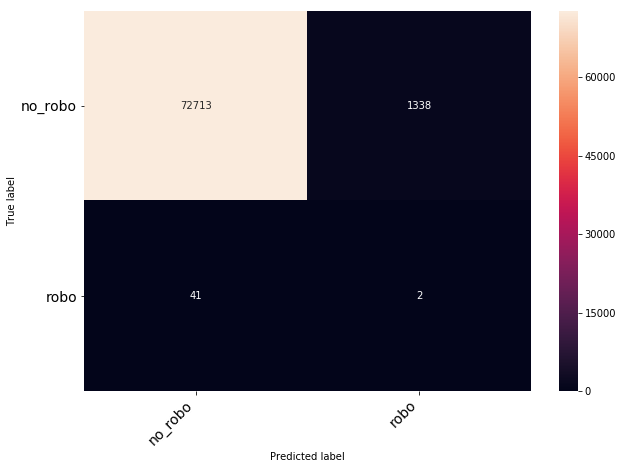

In [38]:
y_pred_classes = (y_pred > 0.01).astype(int) #000133 #0.04
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

0.7006714103071014


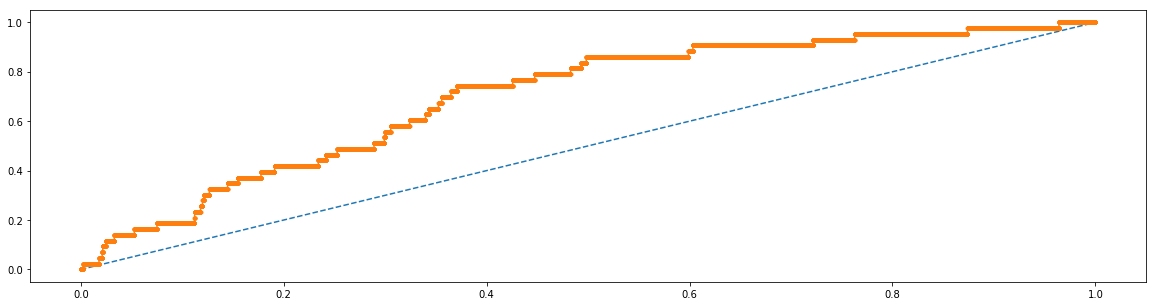

In [39]:
print_roc(y_test, y_pred)

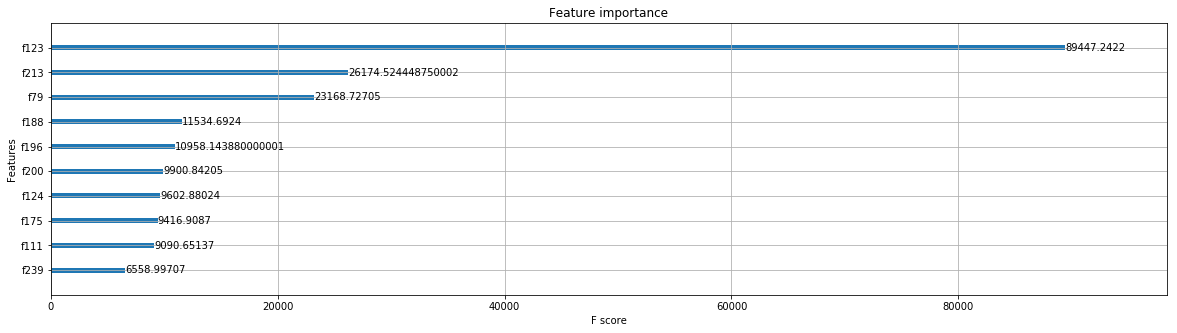

In [164]:
xgb.plot_importance(model, max_num_features=10, importance_type='cover');

In [43]:
X_train.columns[213]

'destination_id_10110'

# What might we do to improve our model results?
* MORE DATA - always good to have more if possible
* New features extracted from existing data:
    * Number of estadías?
    * Play with number of routes passed through, geohashes or otherwise
    * time_travel might be a powerful variable because it is indicating to our model that it is a particular route. Maybe we should create pairwise start+finish columns.
    * Maybe reduce number of columns, under sample and go for more deep learning.
    
* New features created from new data sources:
    * Weather
    * Traffic conditions
    * Third-party security data (governments) about security events

# How can we use this results in a in production solution

* Working backwards. Who are the users? Who will consume this information? How will they consume it?
* Customers - perhaps web app, chat bot, automated system to see why their journey is being marked as dangerous
* 
* Include mockups or demos that Oscar prepared
* 
* How to deploy in AWS (serverless) Lambda. Maybe Sagemaker but perhaps not even necessary.
* Using will require new training and processes

# Implementing our solution in production
* Who/what will use the output of this model?
    * Customers directly (telegram idea)
    * Internal Monitoristas via the dashboard
* AWS Serverless Architecture
    * SageMaker hosted endpoint (sklearn, Xgboost)
    * Lambda
    * API Gateway
    * Automatic retraining (1 per month)
    * Data extraction scripts
* Security


# Conclusions

"When it comes to artificial intelligence, one of the biggest mistakes large companies make is thinking tactically rather than strategically. 

 

What's the difference? Some taxi companies thought they had the internet revolution "covered" because they built a website. Then ride-sharing startups disrupted the industry with internet-connected mobile apps that transformed the ride-hailing experience.

 

Similarly, some companies’ response to AI starts and ends with tactically building a few small projects. But the strategic question is: How will AI transform your industry's core business, and how will that change what it takes for your company to thrive? "